# Модель Изинга на графен-решетке

Мы построим модели Изинга для двух конфигураций - первая точно такая же, как в задании (почти гексагон (графен)), вторая - произвольных габаритов гексагон (графен).
Импортируем все необходимое и создадим необходимые константы:

In [1]:
import cv2
import pickle
import math
import random
import copy
from math import sin, cos, pi, sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

PKL = 'points.pkl'
IMG_NAME = 'graphen.png'

# связи для данной конфиг-ии
LINKS = ((0, 1, 2, 3, 4, 5, 6), (1, 7, 8, 9, 10, 2), (8, 11, 12, 13, 14, 9), (12, 15, 16, 17, 18, 19, 13),
         (3, 2, 10, 25, 21, 20), (10, 9, 14, 32, 29, 26, 25), (14, 13, 19, 36, 33, 32), (24, 20, 21, 22, 23),
         (21, 25, 26, 27, 28, 22), (26, 29, 30, 31, 27), (29, 32, 33, 34, 35, 30), (33, 36, 37, 38, 34),
         (42, 23, 22, 28, 39, 40, 41, 42), (28, 27, 31, 43, 44, 39), (31, 30, 35, 45, 46, 43),
         (35, 34, 38, 47, 48, 49, 45),)

THETA = pi / 3.0  # Angle from one point to the next
HEXES_HIGH = 64  # How many rows of hexes
HEXES_WIDE = 16  # How many hexes in a row
RADIUS = 15  # Size of a hex
HALF_RADIUS = RADIUS / 2.0
HALF_HEX_HEIGHT = sqrt(RADIUS ** 2 - HALF_RADIUS ** 2)

Создадим классы точки и конфигурации:

In [2]:
# точка
class Point:
    x = -1
    y = -1
    id = -1
    links = None

    def __init__(self, id, x=-1, y=-1, links=[]):
        self.x = x
        self.y = y
        self.id = id
        self.links = []
        self.links.extend(links)

# Конфиг-я
class Config:
    points = None
    signs = None
    betta = 1

    def __init__(self, points, betta=1., signs=None):
        self.points = points
        if signs is None:
            signs = {}
            for point in points:
                signs[point.id] = random.choice([1, -1])
        self.signs = signs
        self.betta = betta

    # Клонирование конфиг-ии
    def clone(self):
        conf_new = Config(self.points, self.betta)
        conf_new.signs = copy.deepcopy(self.signs)
        return conf_new

    # Вычисление энергии для конфигурации
    def computeEnergy(self):
        summ = 0
        i = 0
        for point in self.points:
            for link in point.links:
                if point.id < self.points[link].id:
                    summ += self.signs[point.id] * self.signs[self.points[link].id]
                    i += 1
        summ = math.exp(summ * self.betta)
        print(i)
        return summ

    # Вычисление разницы энергий
    def compute_sum_diff(self, num):
        potential_cand = self.points[num]
        summ = 0
        for link in potential_cand.links:
            summ += self.signs[self.points[link].id]
        summ *= self.signs[num]
        return summ

    # Пытаемся перейти в новую конфигурацию, возвращем (успех, следующая конф-я)
    def try_to_move(self, num):
        diff = self.compute_sum_diff(num)
        p = min(1, math.exp(-2. * self.betta * diff))
        move_success = random.random() < p
        if move_success:
            new_conf = self.clone()
            new_conf.signs[num] = - new_conf.signs[num]
            # print 'transition'
            return (True, new_conf)

        return (False, self)



Некоторые необходимые функции с комментариями по генерации точек произвольного хексагона:

In [3]:
# Генератор точек вокруг данного центра
def hex_points(x, y):
    '''Given x and y of the origin, return the six points around the origin of RADIUS distance'''
    for i in range(6):
        yield cos(THETA * i) * RADIUS + x, sin(THETA * i) * RADIUS + y


# Генератор центров хексагонов
def hex_centres():
    for x in range(HEXES_WIDE):
        for y in range(HEXES_HIGH):
            yield (x * 3 + 1) * RADIUS + RADIUS * 1.5 * (y % 2), (y + 1) * HALF_HEX_HEIGHT



# Генератор всех точек
def gen_points():
    points = []
    id = 0
    dict_visited = {}
    neighbors = []
    for x, y in hex_centres():
        hex = list(hex_points(x, y))
        hex_neighb = []
        for point in hex:
            x, y = point
            x = int(round(x))
            y = int(round(y))
            if (x, y) not in dict_visited:
                created_point = Point(id, x, y, [])
                dict_visited[(x, y)] = created_point
                id += 1
                points.append(created_point)

            cur_point = dict_visited[(x, y)]
            hex_neighb.append(cur_point.id)
        neighbors.append(hex_neighb)

    fillLinks(points, neighbors)
    return points

Некоторые функции для работы с картинкой-шаблоном из задания и по рисовке произвольной конфиг-ии:

In [4]:
# Функция для работы с заданной картинкой в задании - позволяет пометить точки на картинке
def pointsMark():
    res = []
    img = cv2.imread(IMG_NAME)
    count = [0]

    def drawPoints(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDBLCLK:
            cv2.circle(img, (x, y), 5, (255, 0, 0), -1)
            cv2.putText(img, str(count[0]), (x + 5, y + 5), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
            print(count[0], x, y)
            res.append(Point(count[0], x, y))
            count[0] += 1

    cv2.namedWindow('image')
    cv2.setMouseCallback('image', drawPoints)
    while (1):
        cv2.imshow('image', img)
        k = cv2.waitKey(20) & 0xFF
        if k == 27:
            break
        elif k == ord('a'):
            break
    cv2.imwrite('points.png', img)
    return res

# Функция-обертка над предыдущей
def startAndSafePoints():
    res = pointsMark()
    with open(PKL, 'wb') as output:
        pickle.dump(res, output, pickle.HIGHEST_PROTOCOL)
    print(len(res))


# Загрузка точек из файла
def loadPoints():
    with open(PKL, 'rb') as input:
        points = pickle.load(input)
        return points


# Заполение связей между точками по константному массиву связей
def fillLinks(points, links):
    for link_set in links:
        for i in range(len(link_set)):
            this_el = link_set[(i) % len(link_set)]
            neighb = link_set[(i + 1) % len(link_set)]
            if neighb not in points[this_el].links:
                points[this_el].links.append(neighb)
            if this_el not in points[neighb].links:
                points[neighb].links.append(this_el)

# Рисует точки и связи
def drawPointsAndLinks(points):
    img = cv2.imread(IMG_NAME)
    for point in points:
        cv2.circle(img, (point.x, point.y), 5, (255, 0, 0), -1)
        cv2.putText(img, str(point.id), (point.x + 5, point.y + 5), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
        for link in point.links:
            neigb = points[link]
            cv2.line(img, (point.x, point.y), (neigb.x, neigb.y), (0, 255, 0), 2)
    #cv2.imshow('image', img)
    #cv2.waitKey()
    plt.figure(figsize = (10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()


# Рисует конфигурацию
def drawConf(conf, font_size=1., figsize=(10,10)):
    points = conf.points
    maxX, maxY = 1, 1
    for point in points:
        if point.x > maxX:
            maxX = point.x + 1
        if point.y > maxY:
            maxY = point.y + 1

    PADDING_X = int(maxX) // 6
    PADDING_Y = int(maxY) // 6
    maxX = int(maxX) + PADDING_X + PADDING_X
    maxY = int(maxY) + PADDING_Y + PADDING_Y
    #img = cv2.imread(IMG_NAME)
    img = np.zeros((maxY, maxX, 3), np.uint8)
    for point in points:
        x = point.x + PADDING_X
        y = point.y + PADDING_Y

        for link in point.links:
            neigb = points[link]
            neigbX = neigb.x + PADDING_X
            neigbY = neigb.y + PADDING_Y
            cv2.line(img, (x, y), (neigbX, neigbY), (122, 122, 122), 2)

        cv2.circle(img, (x, y), 5, (255, 0, 0) if conf.signs[point.id] == -1 else (0, 0, 255), -1)
        #cv2.putText(img, str(point.id), (x + 5, y + 5), cv2.FONT_HERSHEY_SIMPLEX, font_size,
        #            (255, 0, 0) if conf.signs[point.id] == -1 else (0, 0, 255))
    #cv2.imshow('image', img)
    #cv2.waitKey()
    plt.figure(figsize = figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Ключевые функции - циклическая ф-я процесса и точки входа:

In [5]:
# Начинает цикл Марковского процесса
def start_improve_model(start, max):
    cnt = 0
    new_model = start
    while cnt < max:
        new_pos = random.choice(list(new_model.signs.keys()))
        succ, new_model = new_model.try_to_move(new_pos)
        if succ:
            cnt += 1
    return new_model

# Показывает итоговые конфиг-ии  с параметром betta по шаблону-картинке из задания
def demoTemplate(betta=1., iters=10000):
    points = loadPoints()
    fillLinks(points, LINKS)

    conf = Config(points, betta=betta)
    last = start_improve_model(conf, iters)
    drawConf(last)

# Показывает итоговые конфиг-ии  с параметром betta по произвольному гексагону-графену
def demoBig(betta=1., iters=1000):
    points = gen_points()
    conf = Config(points, betta=betta)
    last = start_improve_model(conf, iters)
    drawConf(last, 0.25)

Посмотрим на схему их задания при betta=10, числе итераций=10000 (наблюдаются четкие группы):

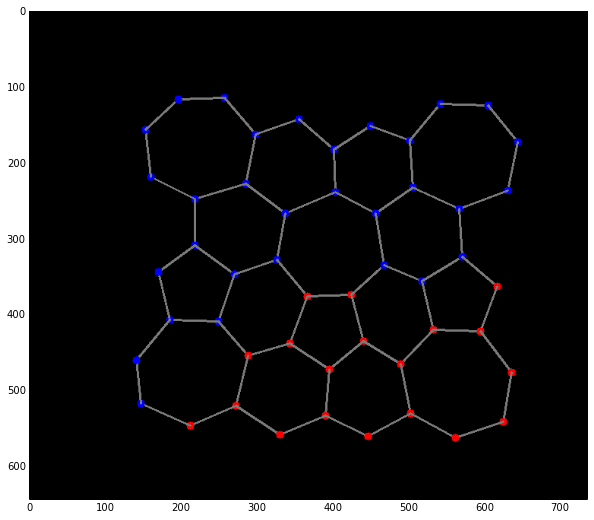

In [6]:
demoTemplate(10., 10000)

Посмотрим на схему их задания при betta=2, числе итераций=10000 (наблюдаются четкие группы):

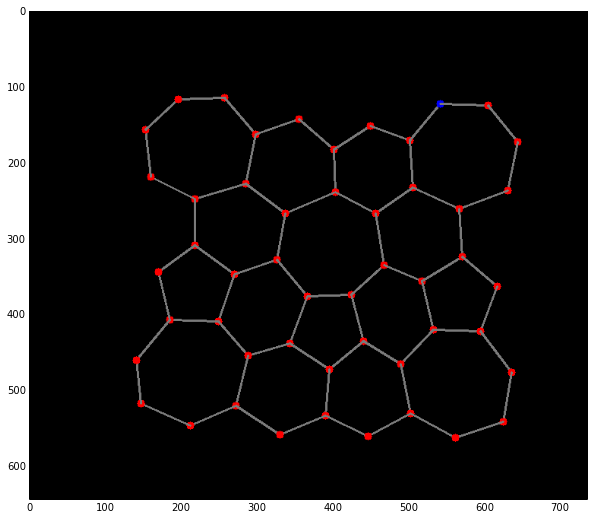

In [7]:
demoTemplate(2., 10000)

Посмотрим на схему их задания при betta=1, числе итераций=10000 (наблюдаются четкие группы):

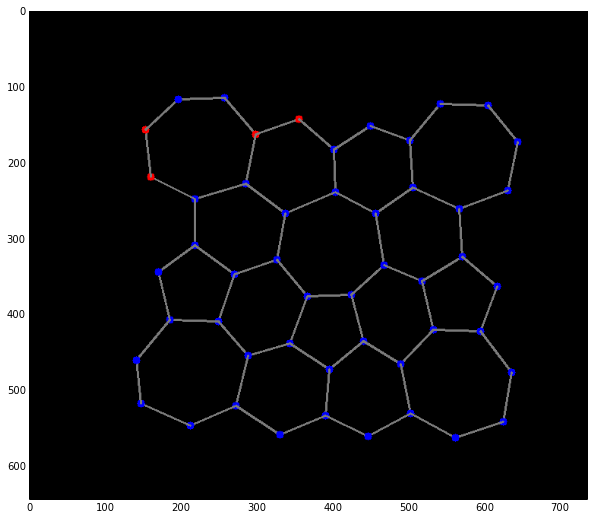

In [8]:
demoTemplate(1., 10000)

Посмотрим на схему их задания при betta=0.5, числе итераций=10000 (наблюдаются группы):

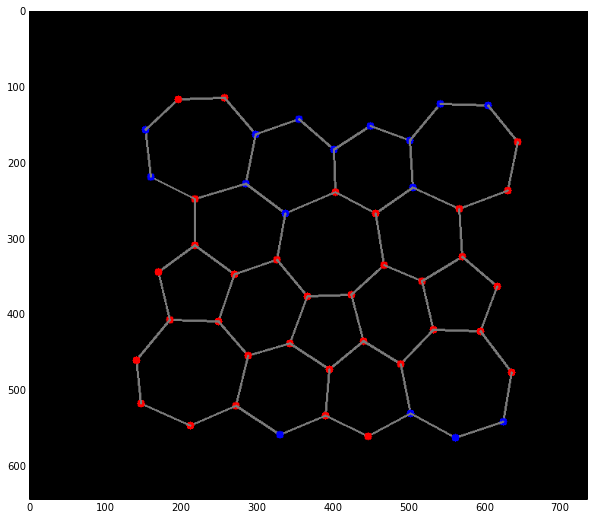

In [9]:
demoTemplate(0.5, 10000)

Посмотрим на схему их задания при betta=0, числе итераций=10000 (наблюдаются маленькие цепочки):

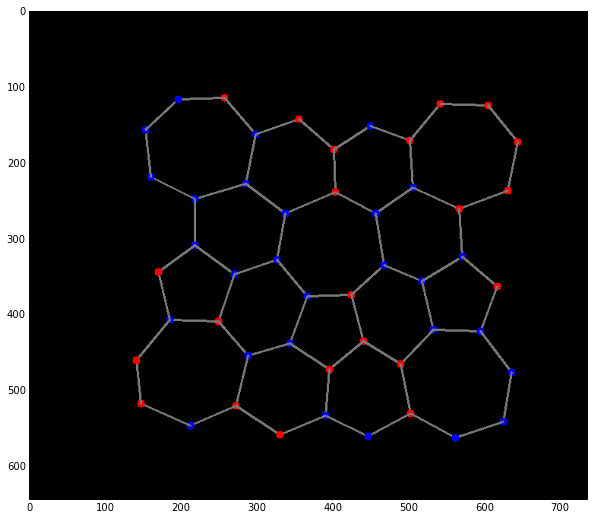

In [10]:
demoTemplate(0., 10000)

Посмотрим на схему их задания при betta=-1, числе итераций=10000 (наблюдается хаотичность):

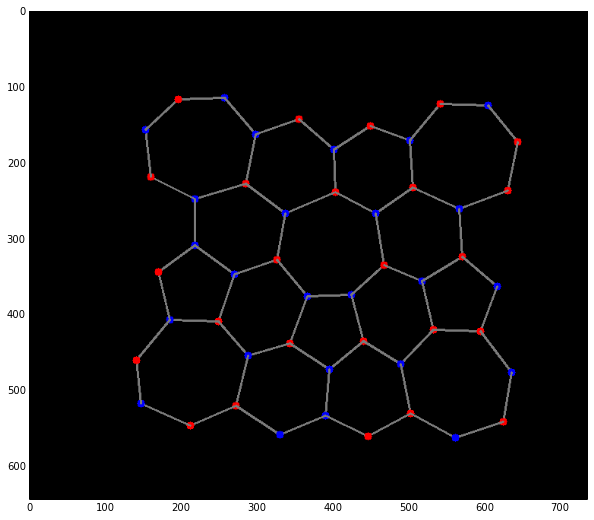

In [11]:
demoTemplate(-1., 10000)

Посмотрим теперь на модель Изинга большой схема-хексагона при betta=10 и числе итераций=10000 (наблюдаются четкие группы):

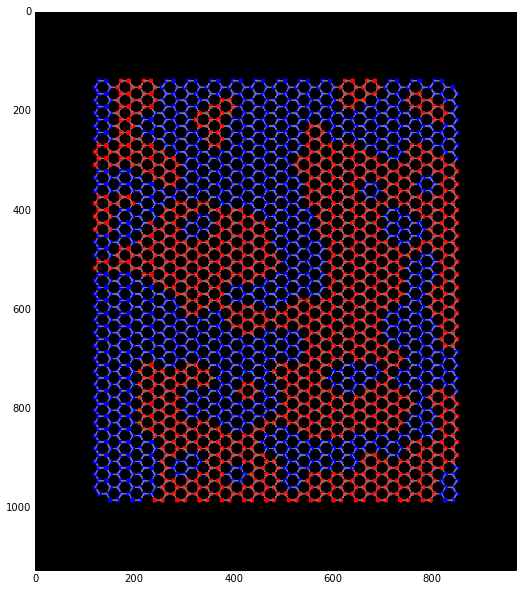

In [12]:
demoBig(10., 10000)

Посмотрим на модель Изинга большой схема-хексагона при betta=3 и числе итераций=10000 (наблюдаются четкие группы):

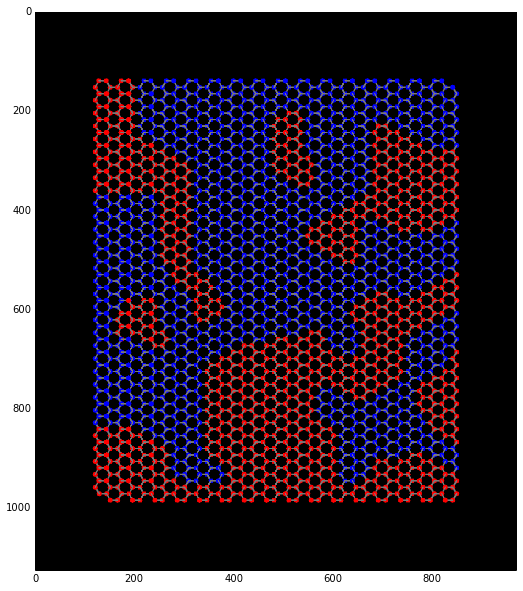

In [13]:
demoBig(3., 10000)

Посмотрим на модель Изинга большой схема-хексагона при betta=1 и числе итераций=10000 (наблюдаются четкие группы):

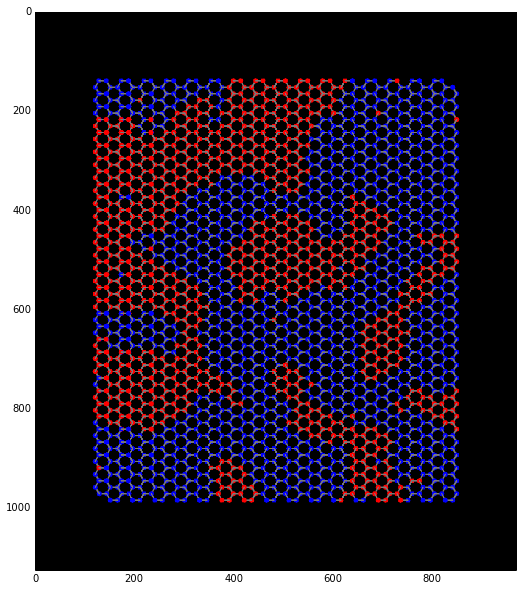

In [14]:
demoBig(1, 10000)

Посмотрим на модель Изинга большой схема-хексагона при betta=0.5 и числе итераций=10000 (группы уменьшаются):

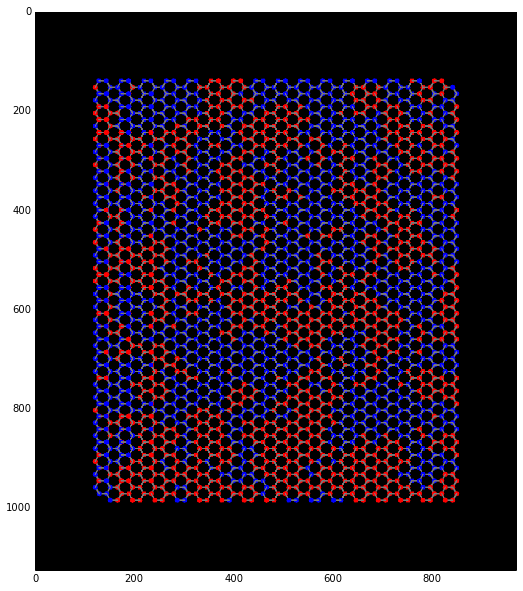

In [15]:
demoBig(0.5, 10000)

Посмотрим на модели Изинга большой схема-хексагона при betta=0 и числе итераций=10000  (наблюдаются маленькие цепочки):

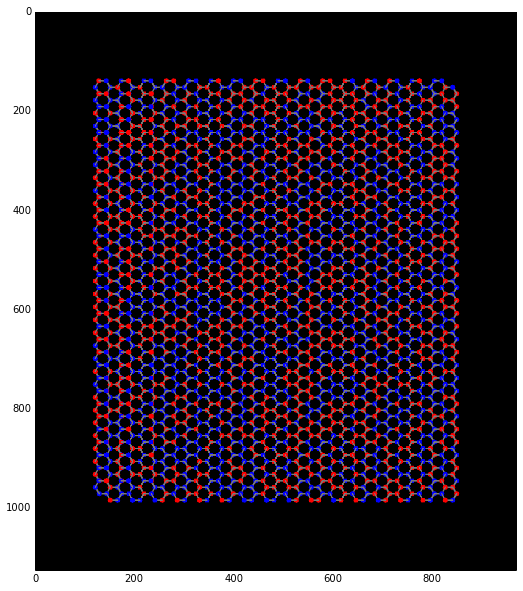

In [16]:
demoBig(0., 10000)

Посмотрим на модели Изинга большой схема-хексагона при betta=-1 и числе итераций=10000  (наблюдается хаотичность "через один" вокруг каждого гексагона):

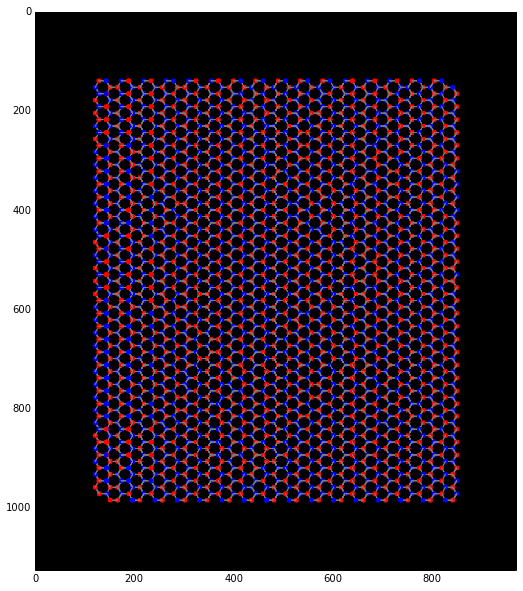

In [17]:
demoBig(-1., 10000)

Посмотрим на модели Изинга большой схема-хексагона при betta=-3 и числе итераций=10000 (наблюдается хаотичность вокруг каждого гексагона):

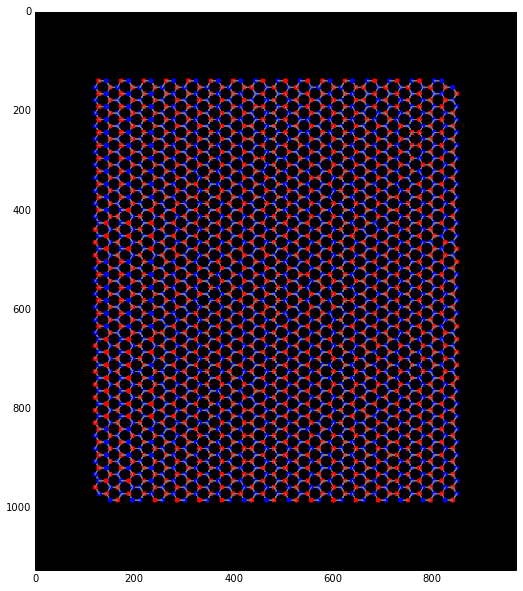

In [18]:
demoBig(-3., 10000)